In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-13 12:11:17.501398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(iv) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/Device-25(iv)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.0703125+0.0390625j  0.0390625-0.0546875j -0.0078125+0.0546875j ...
 -0.0390625+0.0546875j  0.0390625-0.09375j   -0.078125 -0.0078125j]
2048
95015
(2048, 95015)
[0.02549697 0.01474899 0.00491422 ... 0.00467612 0.00479742 0.01456751]
0
(10000, 2048)
(10000,)
[ 0.109375 +0.j         0.09375  +0.078125j  -0.0234375-0.015625j  ...
  0.0234375-0.0390625j -0.0078125+0.0078125j -0.0078125+0.0234375j]
2048
83385
(2048, 83385)
[0.02562689 0.01466803 0.00470259 ... 0.00465174 0.00503456 0.01461309]
1
(20000, 2048)
(20000,)
[ 0.0390625+0.0078125j -0.0078125-0.015625j   0.0546875-0.015625j  ...
  0.109375 -0.0078125j -0.0390625-0.0234375j  0.046875 -0.0078125j]
2048
86384
(2048, 86384)
[0.02593468 0.01466704 0.00534774 ... 0.0049786  0.00478496 0.01484122]
2
(30000, 2048)
(30000,)
[ 0.0546875-0.03125j    0.109375 -0.0546875j -0.078125 -0.0078125j ...
  0.0390625+0.09375j   -0.078125 -0.203125j   0.       -0.0390625j]
2048
82434
(2048, 82434)
[0.02501773 0.01532712 0.00525362 ... 0.00459394 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-25(iv) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-13 12:25:31.344323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.3886 - accuracy: 0.1375
test loss, test acc: [5.388614177703857, 0.13751250505447388]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 2 ... 5 2 5]
5
[[   0    0 5263    6    8 4641   74    8]
 [   0    0 6582   27   55 2868  466    2]
 [   1    0 5681   26   70 3890  329    3]
 [   0    0 4672   43   23 4973  281    8]
 [   0    0 4912    5   11 5002   54   16]
 [   0    0 4836    6   18 5025  111    4]
 [   0    0 5607   12   13 4151  187   30]
 [   0    1 5954    7    2 3571  411   54]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.13      0.57      0.21     10000
           3       0.33      0.00      0.01     10000
           4       0.06      0.00      0.00     10000
           5       0.15      0.50      0.23     10000
           6       0.10      0.02      0.03     10000
           7       0.43      0.01      0.01     10000

    accuracy                           0.14     80000
   macro avg       0.15      0.14  

Test Accuracy:0.1375125


Text(0.5, 1.0, 'Accuracy:0.138')

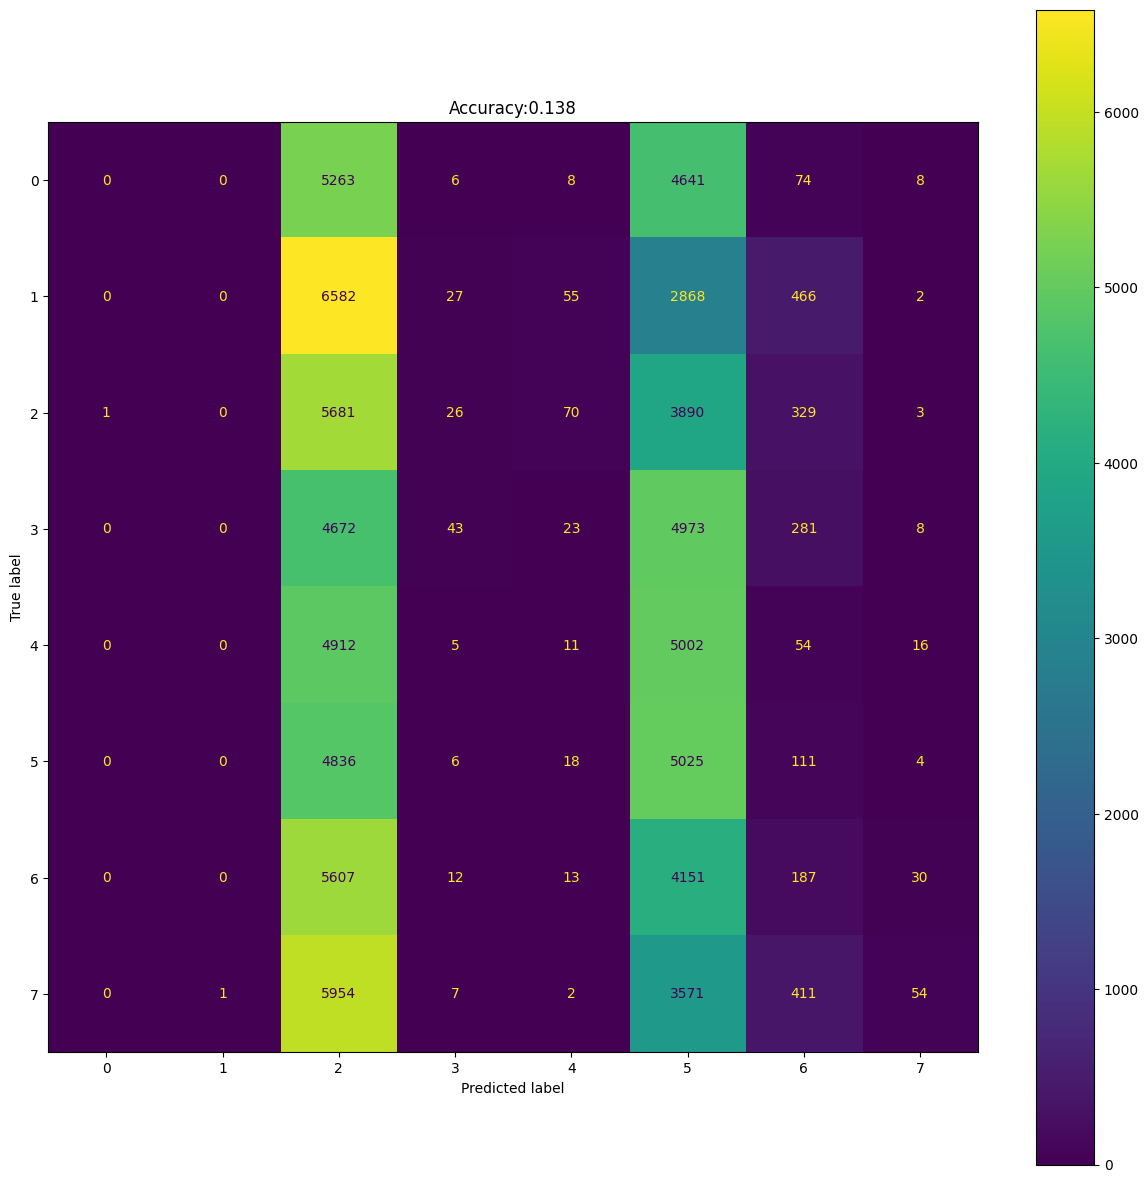

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(i) model to Nordic Device-25(iv) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.7078 - accuracy: 0.1518
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.1626 - accuracy: 0.1792
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.0300 - accuracy: 0.2072
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.9768 - accuracy: 0.2257
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.9460 - accuracy: 0.2424
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9245 - accuracy: 0.2533
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9081 - accuracy: 0.2617
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8951 - accuracy: 0.2679
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8839 - accuracy: 0.2767
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss:

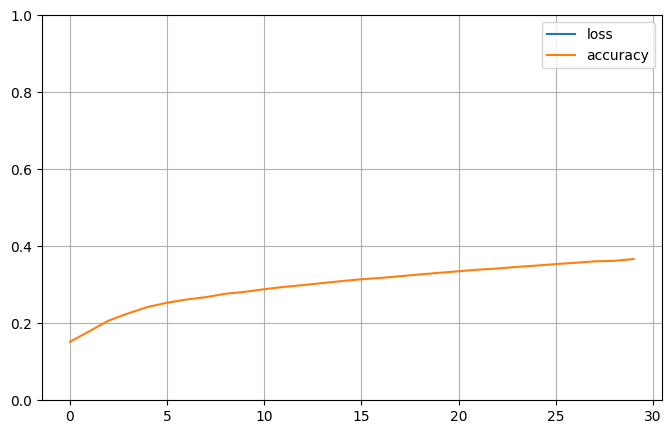

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.7496 - accuracy: 0.3626
test loss, test acc: [1.7495505809783936, 0.36256250739097595]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 5 0 ... 7 7 7]
3
[[1717  835 1427 1014 1934 1574  305 1194]
 [ 475 5474  916  747  502  528  284 1074]
 [ 588 1729 3140 1215  713 1081  216 1318]
 [ 557  939 1289 3846  821  778  314 1456]
 [1144  605 1009  859 3551 1219  273 1340]
 [ 988  846 1577  977 1715 2347  274 1276]
 [ 725 1330 1034 1276 1403  918 1418 1896]
 [ 246  561  522  269  483  354   53 7512]]
              precision    recall  f1-score   support

           0       0.27      0.17      0.21     10000
           1       0.44      0.55      0.49     10000
           2       0.29      0.31      0.30     10000
           3       0.38      0.38      0.38     10000
           4       0.32      0.36      0.34     10000
           5       0.27      0.23      0.25     10000
           6       0.45      0.14      0.22     10000
           7       0.44      0.75      0.56     10000

    accuracy                           0.36     80000
   macro avg       0.36      0.36  

Test Accuracy:0.3625625


Text(0.5, 1.0, 'Accuracy:0.363')

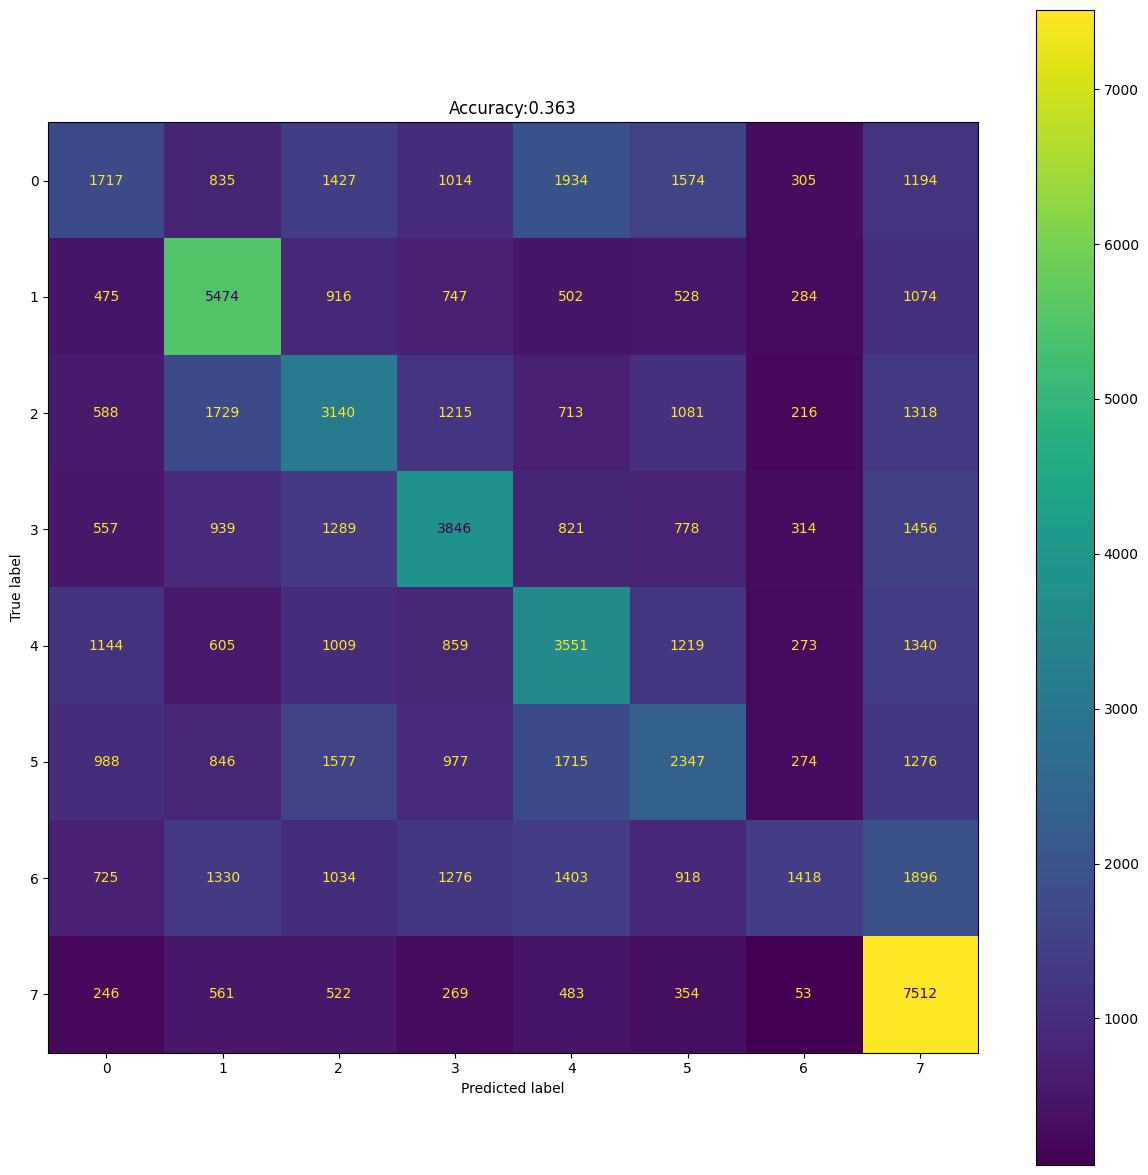

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(ii) model to Nordic Device-25(iv) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 6.0833 - accuracy: 0.1312
test loss, test acc: [6.083317279815674, 0.13124999403953552]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[2 5 2 ... 2 5 2]
2
[[  23    0 3508    0    0 6004  450   15]
 [  38    2 4280    0    2 4755  885   38]
 [   6    3 3354    0    0 5471 1163    3]
 [  28    0 3427    0    1 5940  581   23]
 [  26    0 3197    0    1 6192  576    8]
 [  46    3 3569    0    0 5582  779   21]
 [  12    2 3709    0    1 4750 1522    4]
 [  16    2 3054    0    0 6421  491   16]]
              precision    recall  f1-score   support

           0       0.12      0.00      0.00     10000
           1       0.17      0.00      0.00     10000
           2       0.12      0.34      0.18     10000
           3       0.00      0.00      0.00     10000
           4       0.20      0.00      0.00     10000
           5       0.12      0.56      0.20     10000
           6       0.24      0.15      0.19     10000
           7       0.12      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.14      0.13   

Test Accuracy:0.13125


Text(0.5, 1.0, 'Accuracy:0.131')

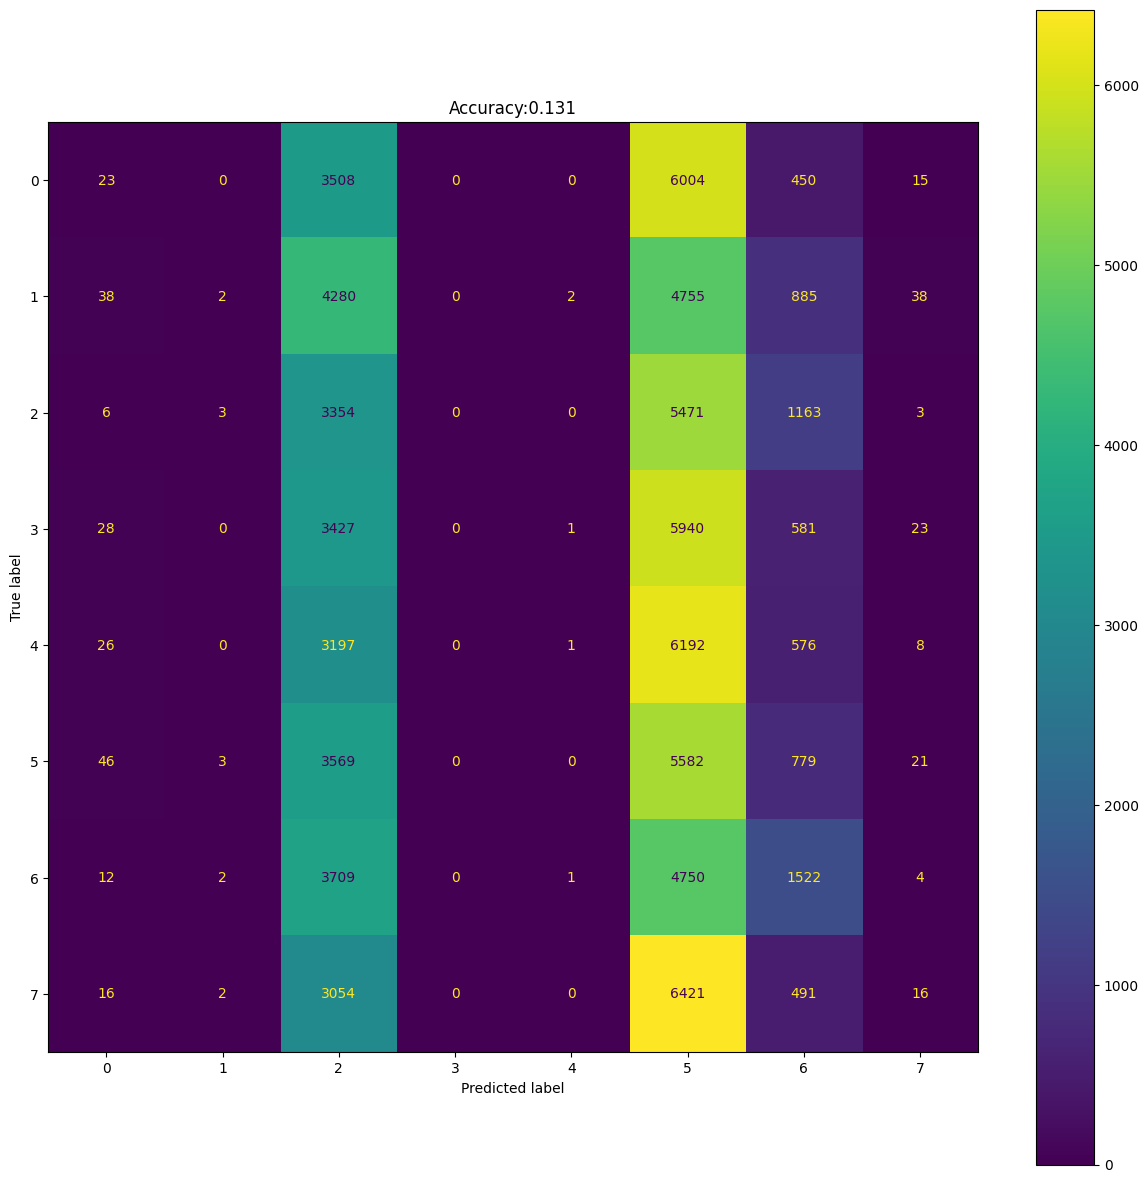

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(ii) model to Nordic Device-25(iv) dataset 

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8719 - accuracy: 0.1423
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.2404 - accuracy: 0.1606
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0705 - accuracy: 0.1802
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0109 - accuracy: 0.2058
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9798 - accuracy: 0.2296
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9587 - accuracy: 0.2480
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9429 - accuracy: 0.2622
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9293 - accuracy: 0.2737
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9176 - accuracy: 0.2841
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

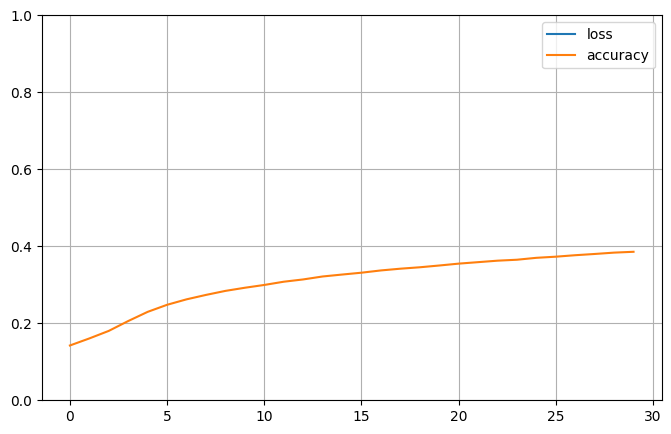

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.7621 - accuracy: 0.3847
test loss, test acc: [1.762147068977356, 0.384674996137619]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[2 0 5 ... 7 7 2]
2
[[2520  826 1873 1310  262 1412  900  897]
 [ 698 4772 1185  676  191  807 1010  661]
 [ 795  628 4709  600  155 1318 1164  631]
 [ 576  552 1142 5157   54 1070  835  614]
 [1829  788 2199 1138  742 1478  900  926]
 [1102  680 2405 1103  177 3023  812  698]
 [ 743  964 2296 1091   99  917 3216  674]
 [ 291  413 1050  456   57  639  459 6635]]
              precision    recall  f1-score   support

           0       0.29      0.25      0.27     10000
           1       0.50      0.48      0.49     10000
           2       0.28      0.47      0.35     10000
           3       0.45      0.52      0.48     10000
           4       0.43      0.07      0.13     10000
           5       0.28      0.30      0.29     10000
           6       0.35      0.32      0.33     10000
           7       0.57      0.66      0.61     10000

    accuracy                           0.38     80000
   macro avg       0.39      0.38  

Test Accuracy:0.384675


Text(0.5, 1.0, 'Accuracy:0.385')

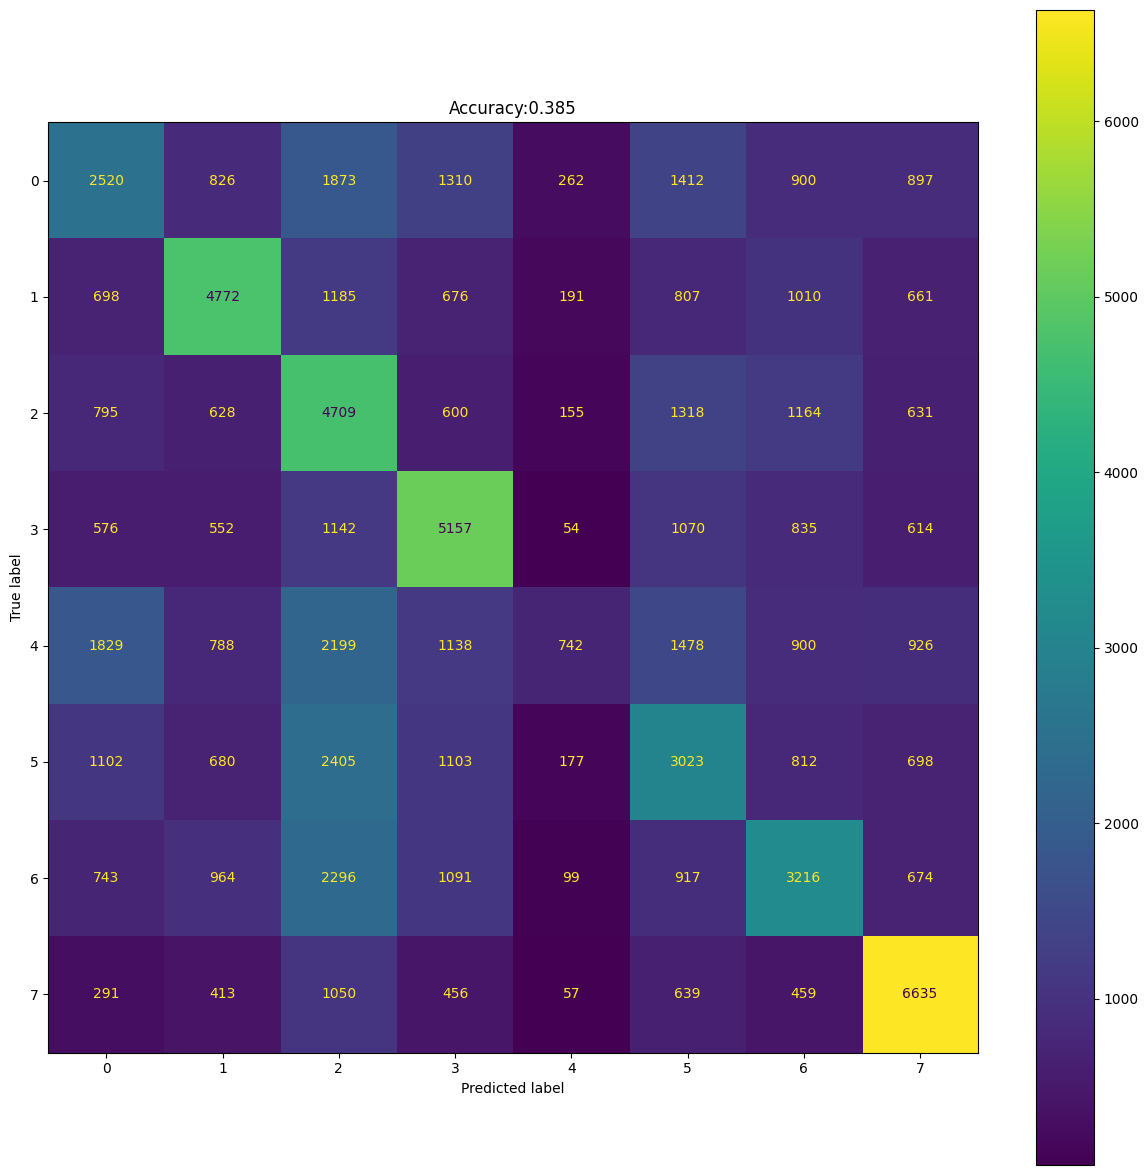

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-25(iv) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1396 - accuracy: 0.7212
test loss, test acc: [1.1395912170410156, 0.7211874723434448]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[2 5 2 ... 7 7 7]
2
[[4878    6  599   72 1794 2338  297   16]
 [   3 9925   35    2    2   16   17    0]
 [ 302  133 5887   92   70 1900 1584   32]
 [  10   14   79 9691    9  118   64   15]
 [5588    3  300   76 1596 2090  345    2]
 [ 406   84 1113  227  262 7096  715   97]
 [  14  151  550   35   16  506 8699   29]
 [   4    6    5    5   15   31   11 9923]]
              precision    recall  f1-score   support

           0       0.44      0.49      0.46     10000
           1       0.96      0.99      0.98     10000
           2       0.69      0.59      0.63     10000
           3       0.95      0.97      0.96     10000
           4       0.42      0.16      0.23     10000
           5       0.50      0.71      0.59     10000
           6       0.74      0.87      0.80     10000
           7       0.98      0.99      0.99     10000

    accuracy                           0.72     80000
   macro avg       0.71      0.72  

Test Accuracy:0.7211875


Text(0.5, 1.0, 'Accuracy:0.721')

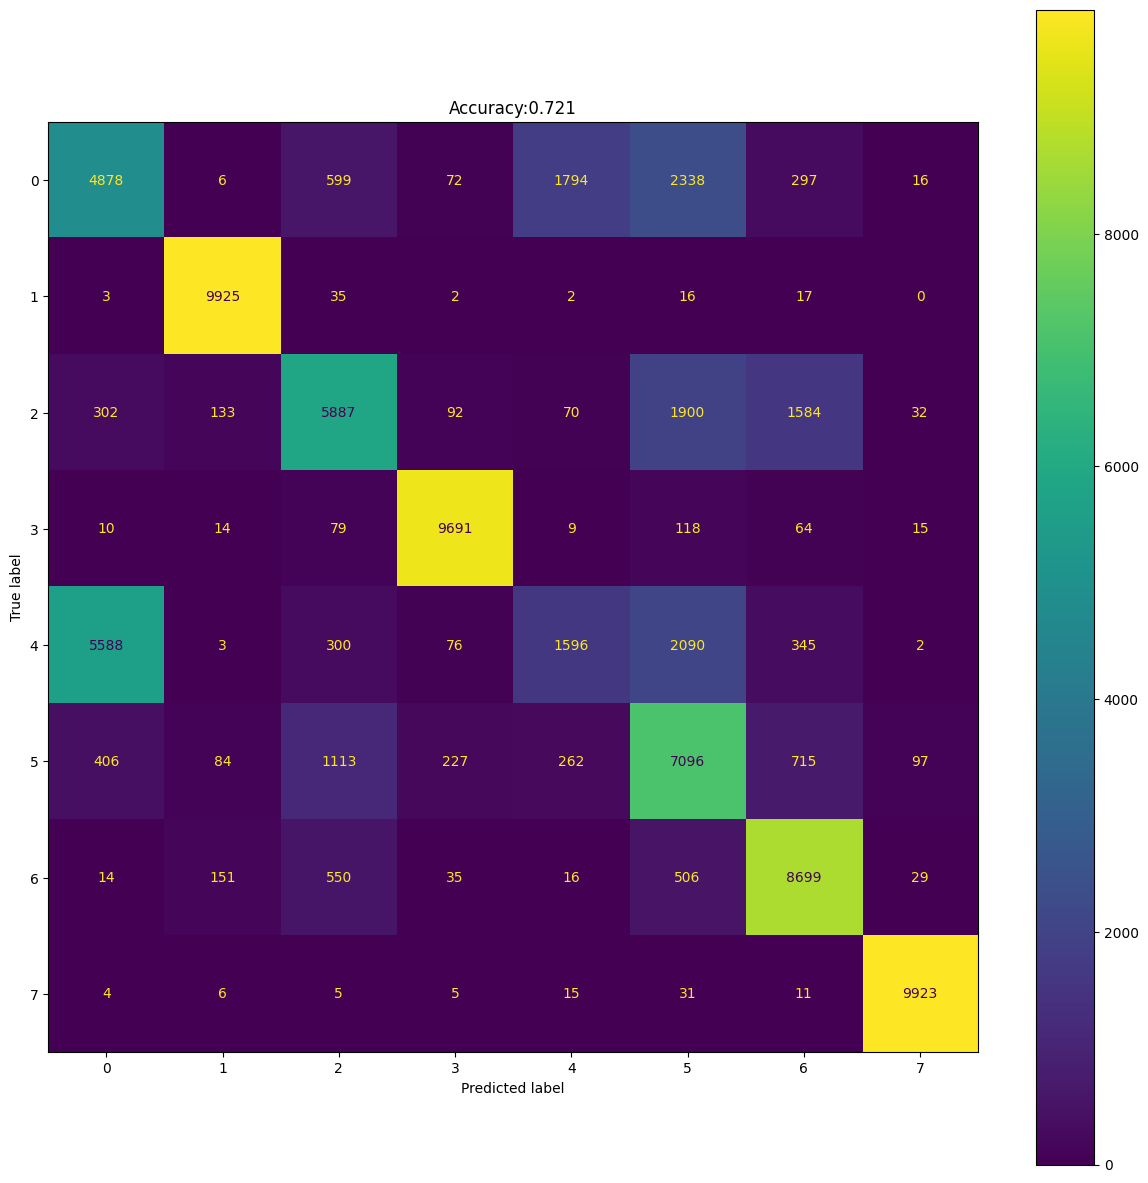

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.8640 - accuracy: 0.7337
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6675 - accuracy: 0.7449
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5941 - accuracy: 0.7545
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5704 - accuracy: 0.7614
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5589 - accuracy: 0.7665
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5516 - accuracy: 0.7697
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5464 - accuracy: 0.7737
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5428 - accuracy: 0.7750
Epoch 9/30
2500/2500 [==============================] - 9s 3ms/step - loss: 0.5400 - accuracy: 0.7768
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.

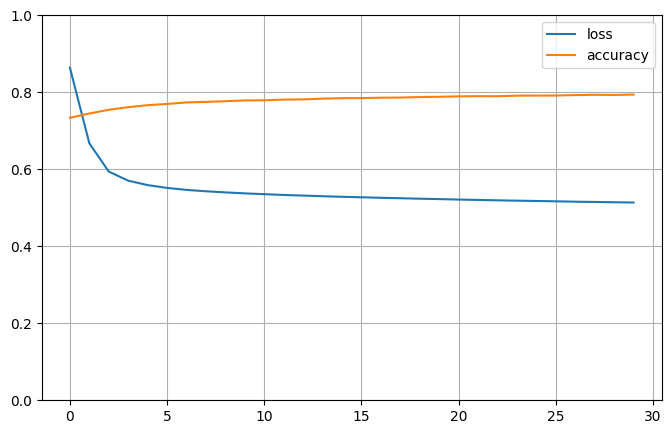

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5129 - accuracy: 0.7949
test loss, test acc: [0.5128501653671265, 0.7949249744415283]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 2 ... 7 7 7]
0
[[4513    0  525   15 3566 1298   82    1]
 [   3 9940   30    1    1   14   11    0]
 [ 316    1 7225   36   83 1464  873    2]
 [  10    1   65 9759   16  115   31    3]
 [2539    0  185   22 6452  758   43    1]
 [ 718    2 1297   88  482 7047  338   28]
 [  16    2  853   20   37  327 8743    2]
 [   2    3   13    3    2   47   15 9915]]
              precision    recall  f1-score   support

           0       0.56      0.45      0.50     10000
           1       1.00      0.99      1.00     10000
           2       0.71      0.72      0.72     10000
           3       0.98      0.98      0.98     10000
           4       0.61      0.65      0.63     10000
           5       0.64      0.70      0.67     10000
           6       0.86      0.87      0.87     10000
           7       1.00      0.99      0.99     10000

    accuracy                           0.79     80000
   macro avg       0.79      0.79  

Test Accuracy:0.794925


Text(0.5, 1.0, 'Accuracy:0.795')

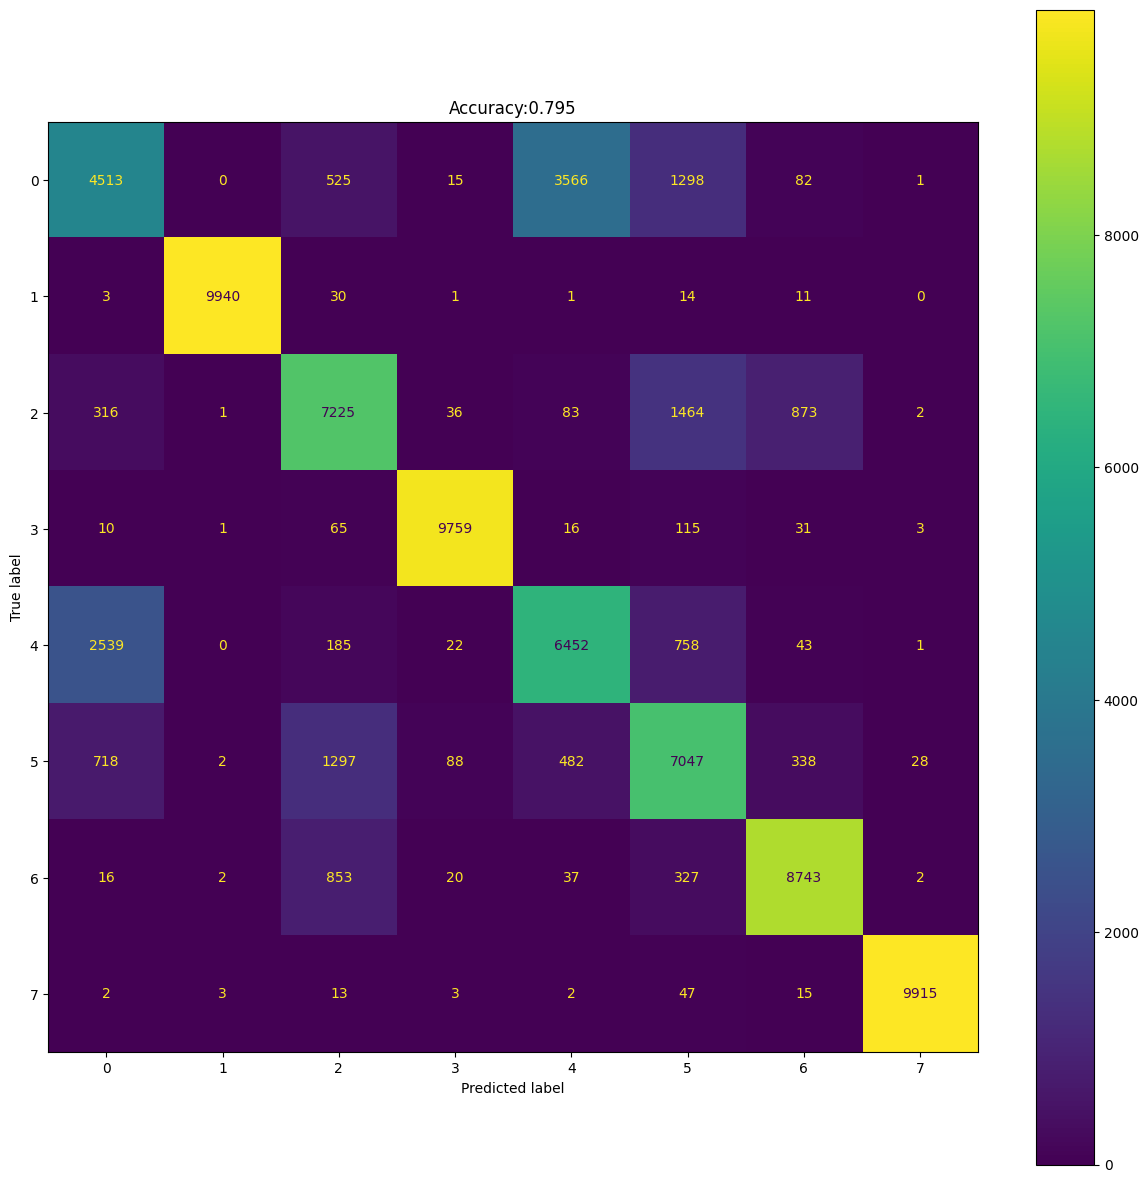

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-25(iv) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.2584 - accuracy: 0.6905
test loss, test acc: [1.2584235668182373, 0.6905249953269958]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 0 4 ... 7 4 7]
4
[[2273    2  862   90 4376 2348   33   16]
 [   0 9945   21    3    5   26    0    0]
 [  47   27 7863  116   62 1752  128    5]
 [   9    5  140 9579   16  246    0    5]
 [1849    2  227   24 6992  896    6    4]
 [ 210   14 1092  235  544 7831   40   34]
 [  21  129 7456   19   38  546 1784    7]
 [   8   10   65  302  147  490    3 8975]]
              precision    recall  f1-score   support

           0       0.51      0.23      0.32     10000
           1       0.98      0.99      0.99     10000
           2       0.44      0.79      0.57     10000
           3       0.92      0.96      0.94     10000
           4       0.57      0.70      0.63     10000
           5       0.55      0.78      0.65     10000
           6       0.89      0.18      0.30     10000
           7       0.99      0.90      0.94     10000

    accuracy                           0.69     80000
   macro avg       0.73      0.69  

Test Accuracy:0.690525


Text(0.5, 1.0, 'Accuracy:0.691')

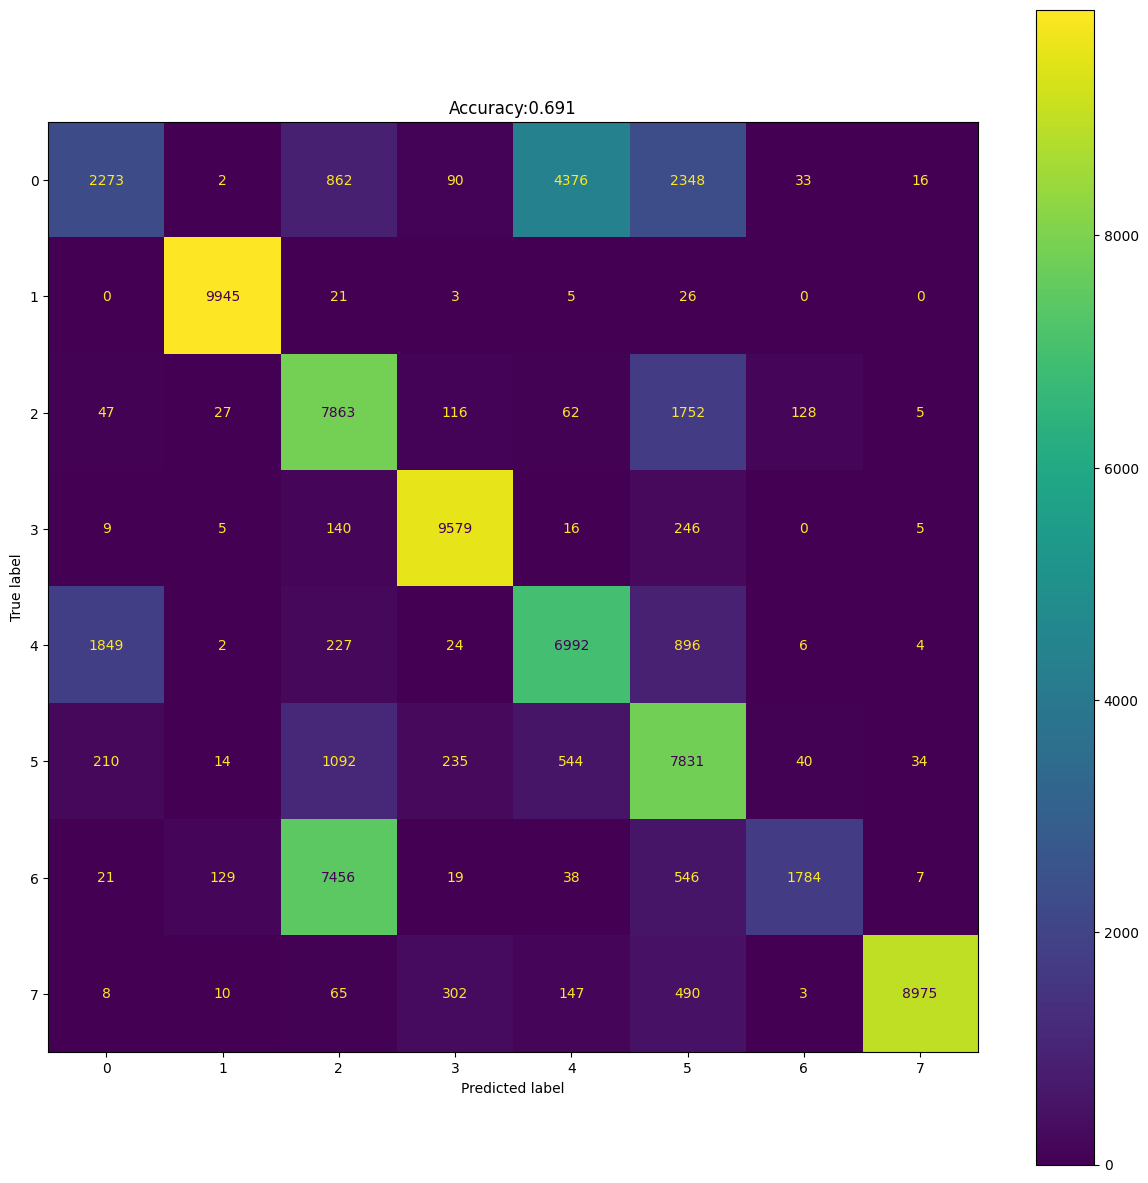

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-25(iv) dataset 

In [41]:
model = keras.models.load_model("//Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.8379 - accuracy: 0.7299
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6873 - accuracy: 0.7440
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6347 - accuracy: 0.7532
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6130 - accuracy: 0.7594
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6015 - accuracy: 0.7629
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5950 - accuracy: 0.7663
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5905 - accuracy: 0.7676
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5869 - accuracy: 0.7692
Epoch 9/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.5843 - accuracy: 0.7702
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

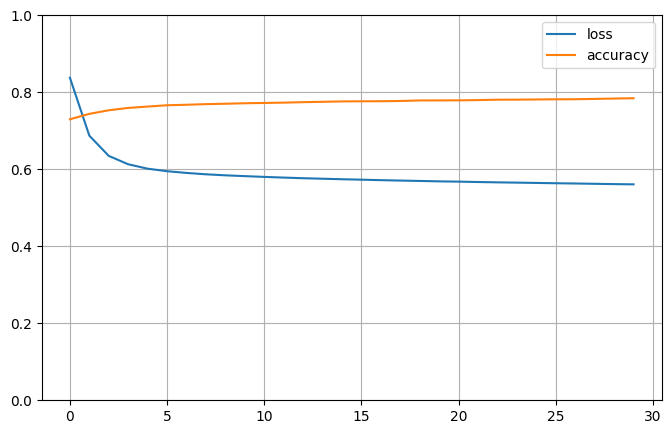

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5603 - accuracy: 0.7847
test loss, test acc: [0.560299277305603, 0.7846999764442444]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[4307    0  635   50 3322 1462  174   50]
 [   5 9944   17    2    0   28    2    2]
 [ 229    0 7280   80    6  945 1434   26]
 [  33    0   60 9708    5  129   46   19]
 [2869    0   93   15 6574  375   37   37]
 [1200    5  936  178   92 7251  199  139]
 [  86    6 1569    9    4  237 8082    7]
 [  76    1   37   67   29  149   11 9630]]
              precision    recall  f1-score   support

           0       0.49      0.43      0.46     10000
           1       1.00      0.99      1.00     10000
           2       0.69      0.73      0.71     10000
           3       0.96      0.97      0.97     10000
           4       0.66      0.66      0.66     10000
           5       0.69      0.73      0.70     10000
           6       0.81      0.81      0.81     10000
           7       0.97      0.96      0.97     10000

    accuracy                           0.78     80000
   macro avg       0.78      0.78  

Test Accuracy:0.7847


Text(0.5, 1.0, 'Accuracy:0.785')

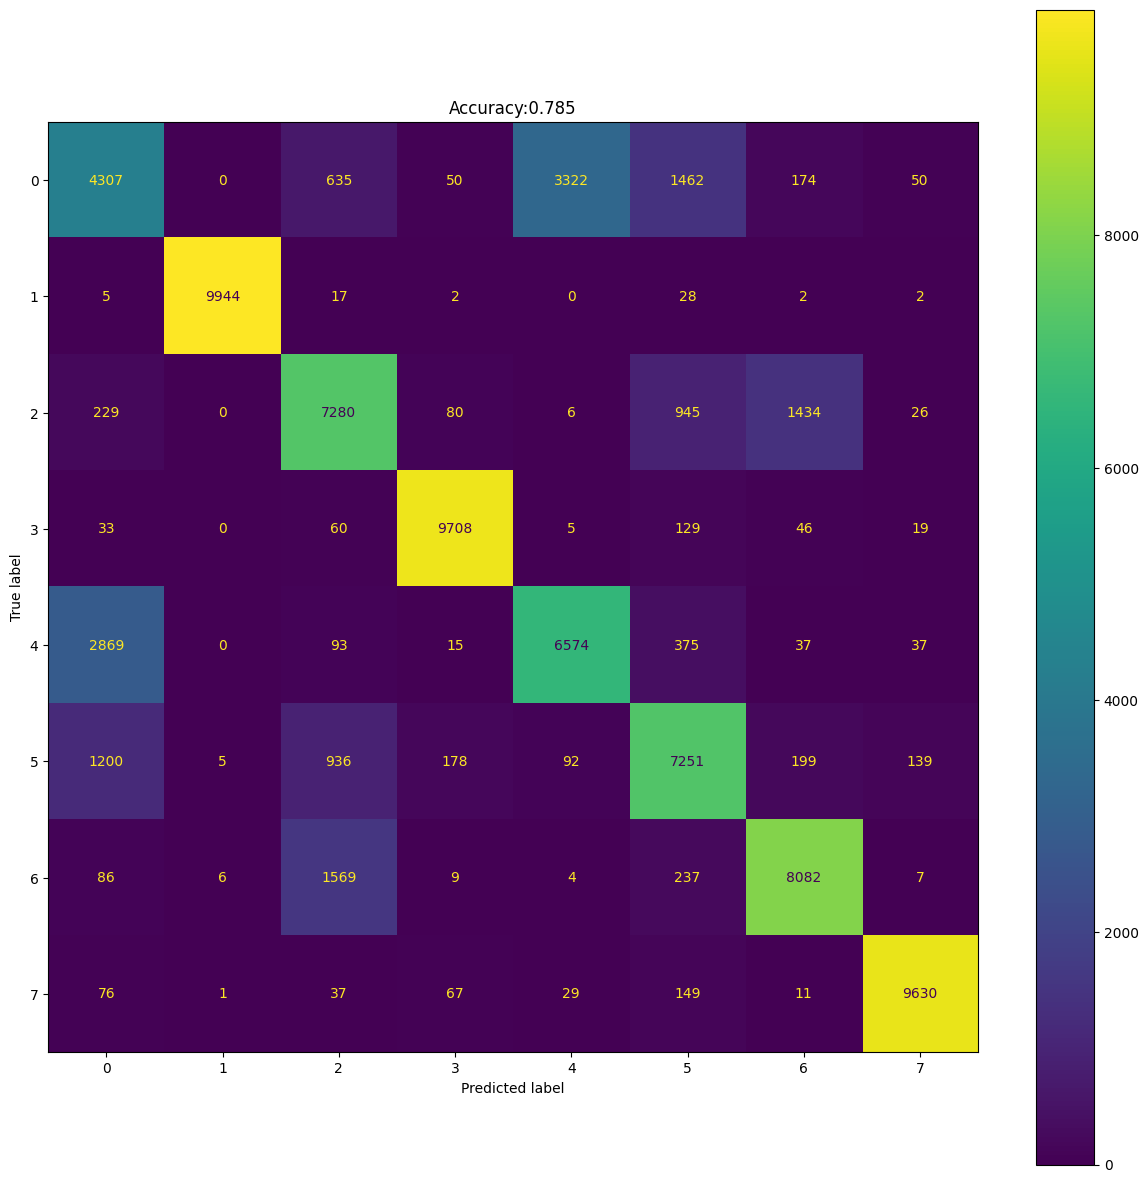

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(iv) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 6.9807 - accuracy: 0.1217
test loss, test acc: [6.980722427368164, 0.12173750251531601]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[6 2 2 ... 2 5 5]
6
[[   0    0 8211    3    0  962  823    1]
 [   0    0 9153   23    0  583  236    5]
 [   1    0 8484   11    0  616  888    0]
 [   0    0 8334    3    0  615 1048    0]
 [   0    0 7879    1    0  851 1269    0]
 [   0    0 8033    2    0  700 1265    0]
 [   0    3 8652   48    0  734  551   12]
 [   0    0 9018    1    0  506  474    1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.13      0.85      0.22     10000
           3       0.03      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.07      0.09     10000
           6       0.08      0.06      0.07     10000
           7       0.05      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.05      0.12  

Test Accuracy:0.1217375


Text(0.5, 1.0, 'Accuracy:0.122')

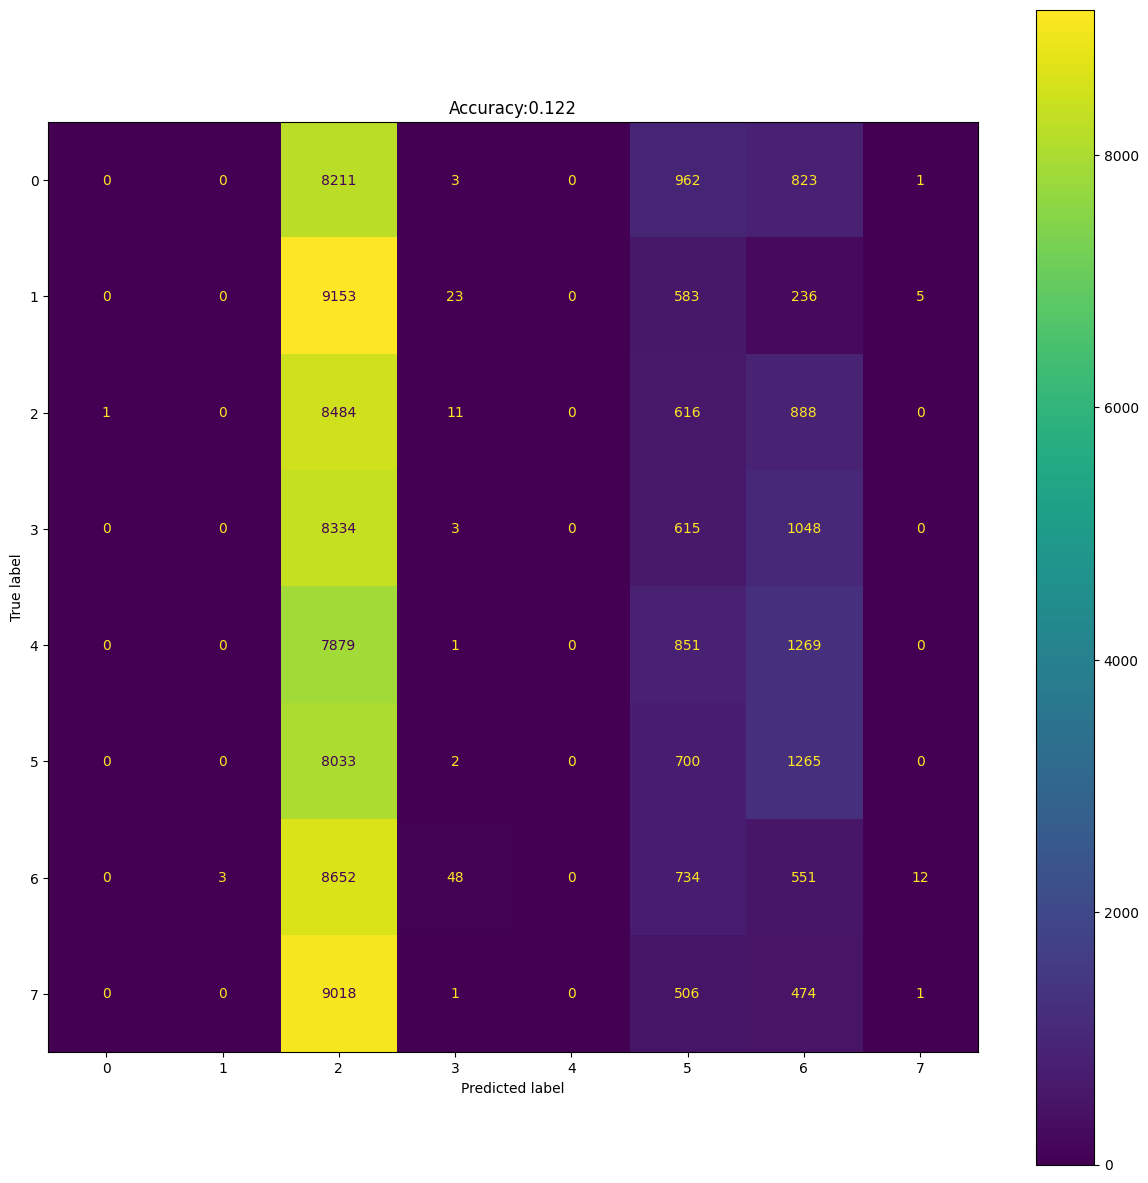

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.7615 - accuracy: 0.1561
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.1289 - accuracy: 0.2008
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.9615 - accuracy: 0.2306
Epoch 4/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.8986 - accuracy: 0.2617
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.8632 - accuracy: 0.2832
Epoch 6/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.8392 - accuracy: 0.3018
Epoch 7/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.8191 - accuracy: 0.3150
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8026 - accuracy: 0.3266
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7879 - accuracy: 0.3365
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

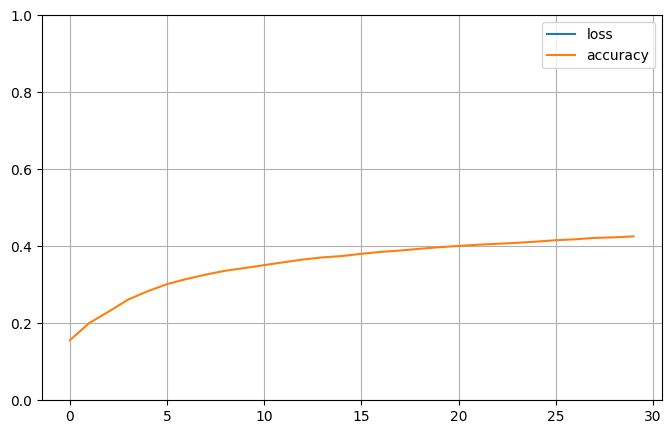

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.6220 - accuracy: 0.4252
test loss, test acc: [1.6219779253005981, 0.42518749833106995]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 0 1 ... 7 0 7]
5
[[2347 1103 1274  803  664 1354 1002 1453]
 [ 450 6014  427  413   50  388 1631  627]
 [ 911  850 2911  436  210 1433 1768 1481]
 [ 688  979  842 3999  290  971 1296  935]
 [1483  687 1299  935 1467 1582  985 1562]
 [ 945  851 1433  926  340 2892 1153 1460]
 [ 130 1104  713  411   57  323 6879  383]
 [ 221  316  456  190  169  460  682 7506]]
              precision    recall  f1-score   support

           0       0.33      0.23      0.27     10000
           1       0.51      0.60      0.55     10000
           2       0.31      0.29      0.30     10000
           3       0.49      0.40      0.44     10000
           4       0.45      0.15      0.22     10000
           5       0.31      0.29      0.30     10000
           6       0.45      0.69      0.54     10000
           7       0.49      0.75      0.59     10000

    accuracy                           0.43     80000
   macro avg       0.42      0.43  

Test Accuracy:0.4251875


Text(0.5, 1.0, 'Accuracy:0.425')

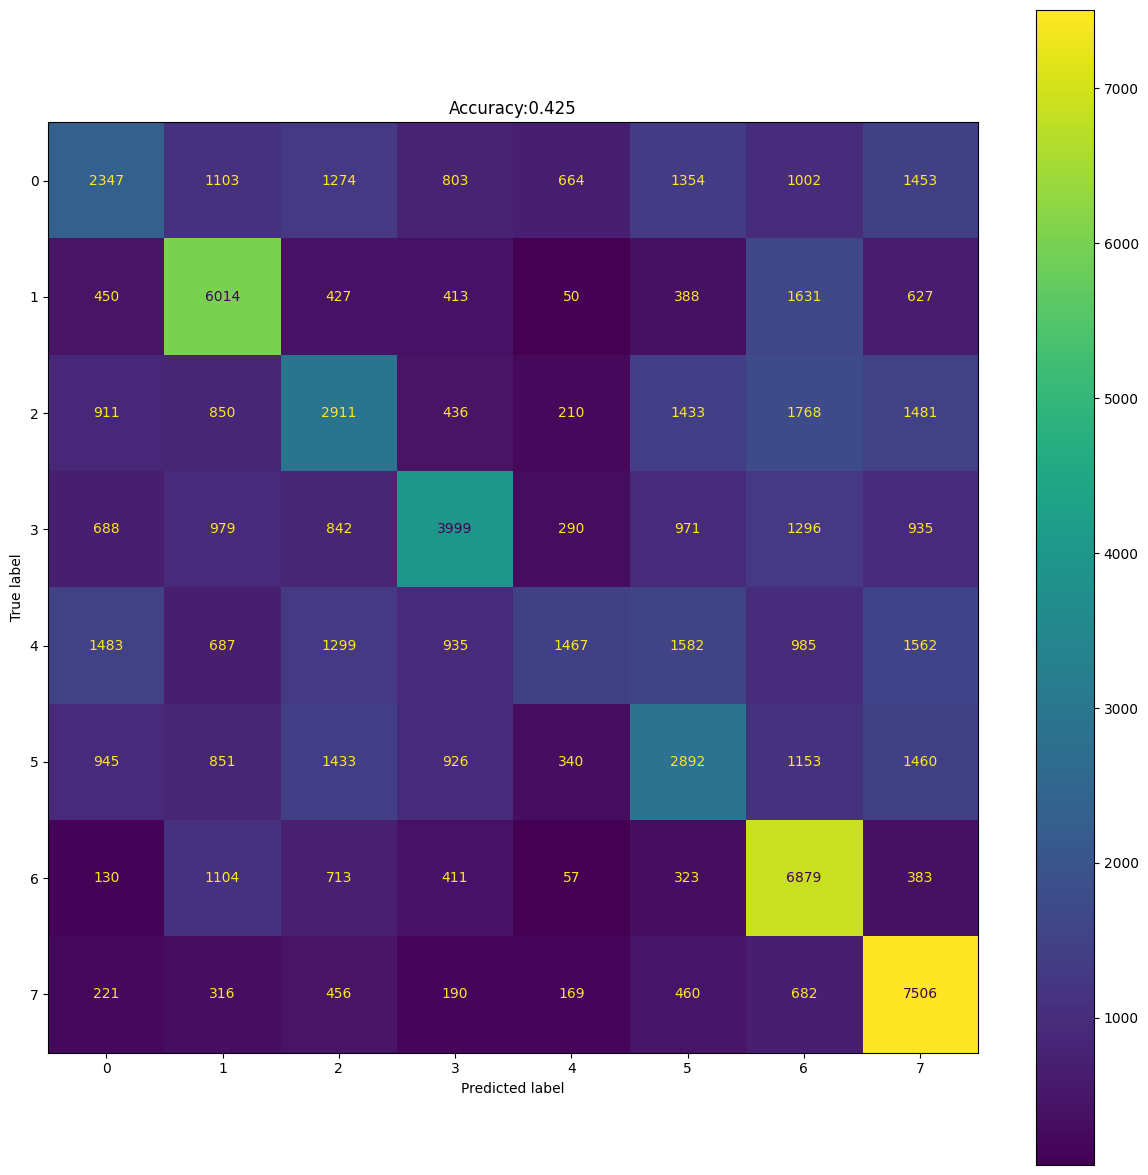

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(iv) dataset 

In [59]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [60]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 8.6147 - accuracy: 0.1296
test loss, test acc: [8.614734649658203, 0.1295749992132187]


In [61]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[2 5 5 ... 6 2 2]
2
[[  24    3 2757    1    0 6526  688    1]
 [   0    9 1434    9    0 8355  192    1]
 [   6    2 3210    2    0 6383  391    6]
 [  22    0 1937    0    0 7507  533    1]
 [  23    0 2148    0    0 7213  613    3]
 [  22    1 3153    1    0 6234  586    3]
 [   3   31 2752    5    0 6289  882   38]
 [   7    3 3165    2    0 6077  739    7]]
              precision    recall  f1-score   support

           0       0.22      0.00      0.00     10000
           1       0.18      0.00      0.00     10000
           2       0.16      0.32      0.21     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.11      0.62      0.19     10000
           6       0.19      0.09      0.12     10000
           7       0.12      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.12      0.13   

Test Accuracy:0.129575


Text(0.5, 1.0, 'Accuracy:0.130')

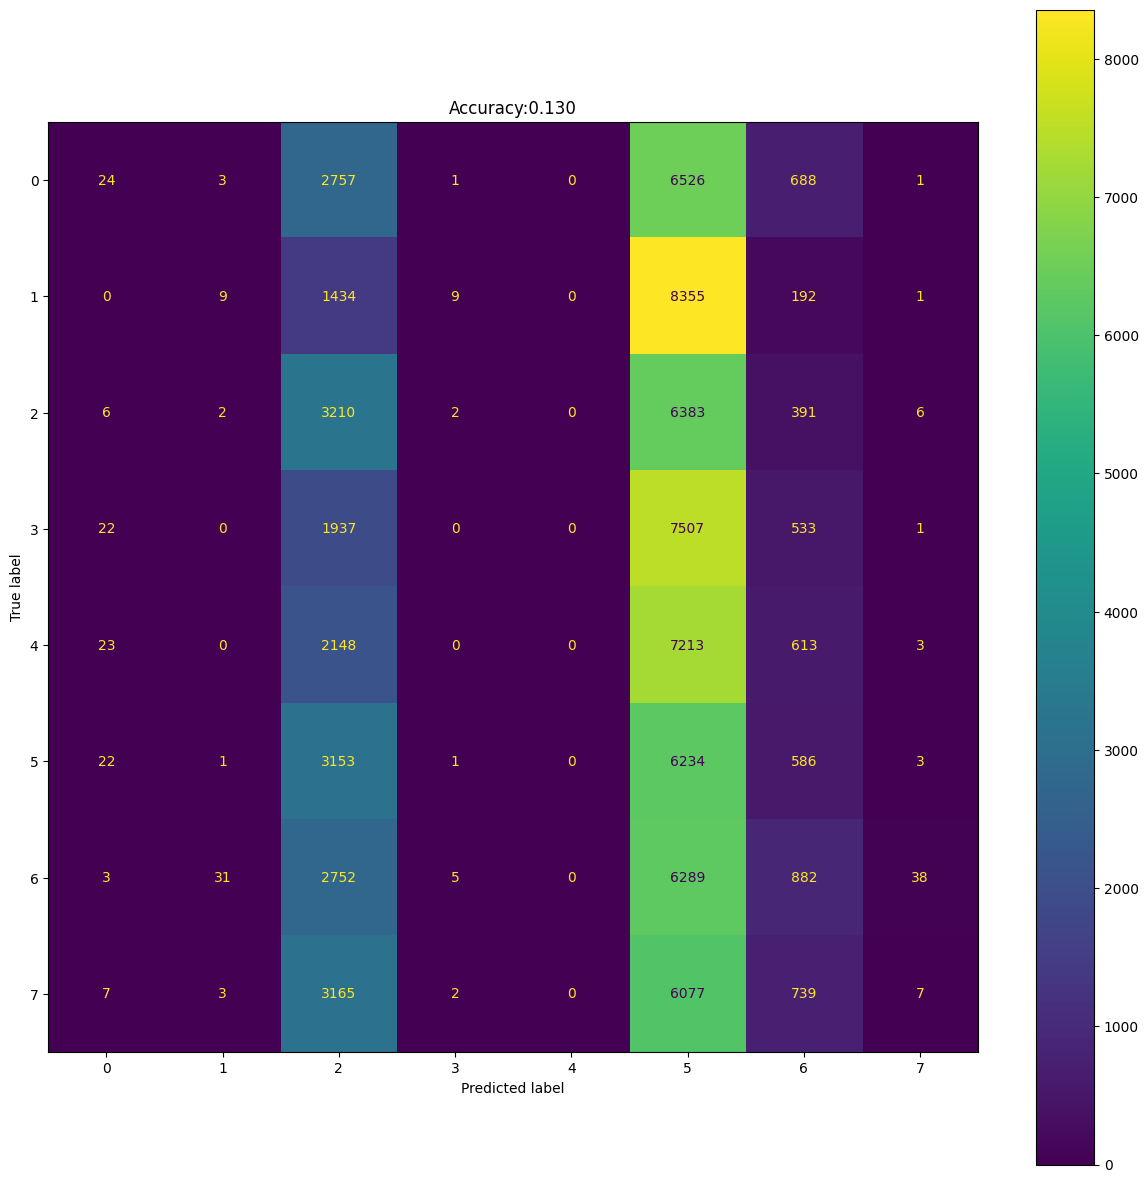

In [62]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [63]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [64]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [65]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.9057 - accuracy: 0.1590
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.1265 - accuracy: 0.1954
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.9827 - accuracy: 0.2255
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9218 - accuracy: 0.2527
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8867 - accuracy: 0.2744
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8607 - accuracy: 0.2895
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8395 - accuracy: 0.3043
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8215 - accuracy: 0.3167
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8055 - accuracy: 0.3288
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.

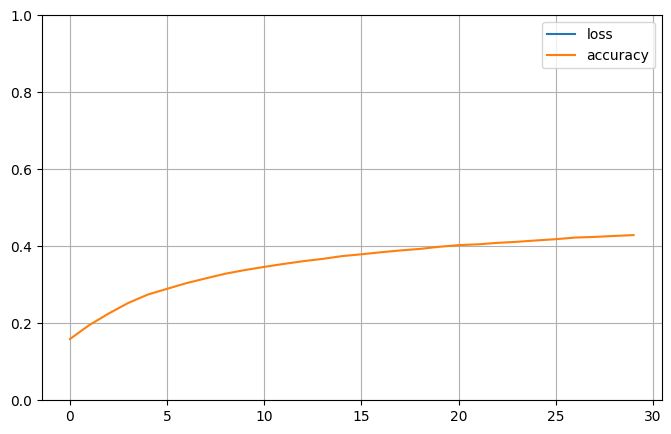

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [67]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.6233 - accuracy: 0.4243
test loss, test acc: [1.623266339302063, 0.42434999346733093]


In [68]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[6 0 0 ... 7 2 6]
6
[[4407  887  559 1296  411  227 1469  744]
 [ 323 8066  238  186   98   73  830  186]
 [2128 1834 1469  891  155  284 2305  934]
 [1290  591  289 5855  129  105  947  794]
 [3569 1060  509 1567  999  268 1319  709]
 [3015  984  783 1421  314  750 1589 1144]
 [1335 1325  521  803   83  141 5146  646]
 [ 578  763  216  469   56   99  563 7256]]
              precision    recall  f1-score   support

           0       0.26      0.44      0.33     10000
           1       0.52      0.81      0.63     10000
           2       0.32      0.15      0.20     10000
           3       0.47      0.59      0.52     10000
           4       0.44      0.10      0.16     10000
           5       0.39      0.07      0.13     10000
           6       0.36      0.51      0.43     10000
           7       0.58      0.73      0.65     10000

    accuracy                           0.42     80000
   macro avg       0.42      0.42  

Test Accuracy:0.42435


Text(0.5, 1.0, 'Accuracy:0.424')

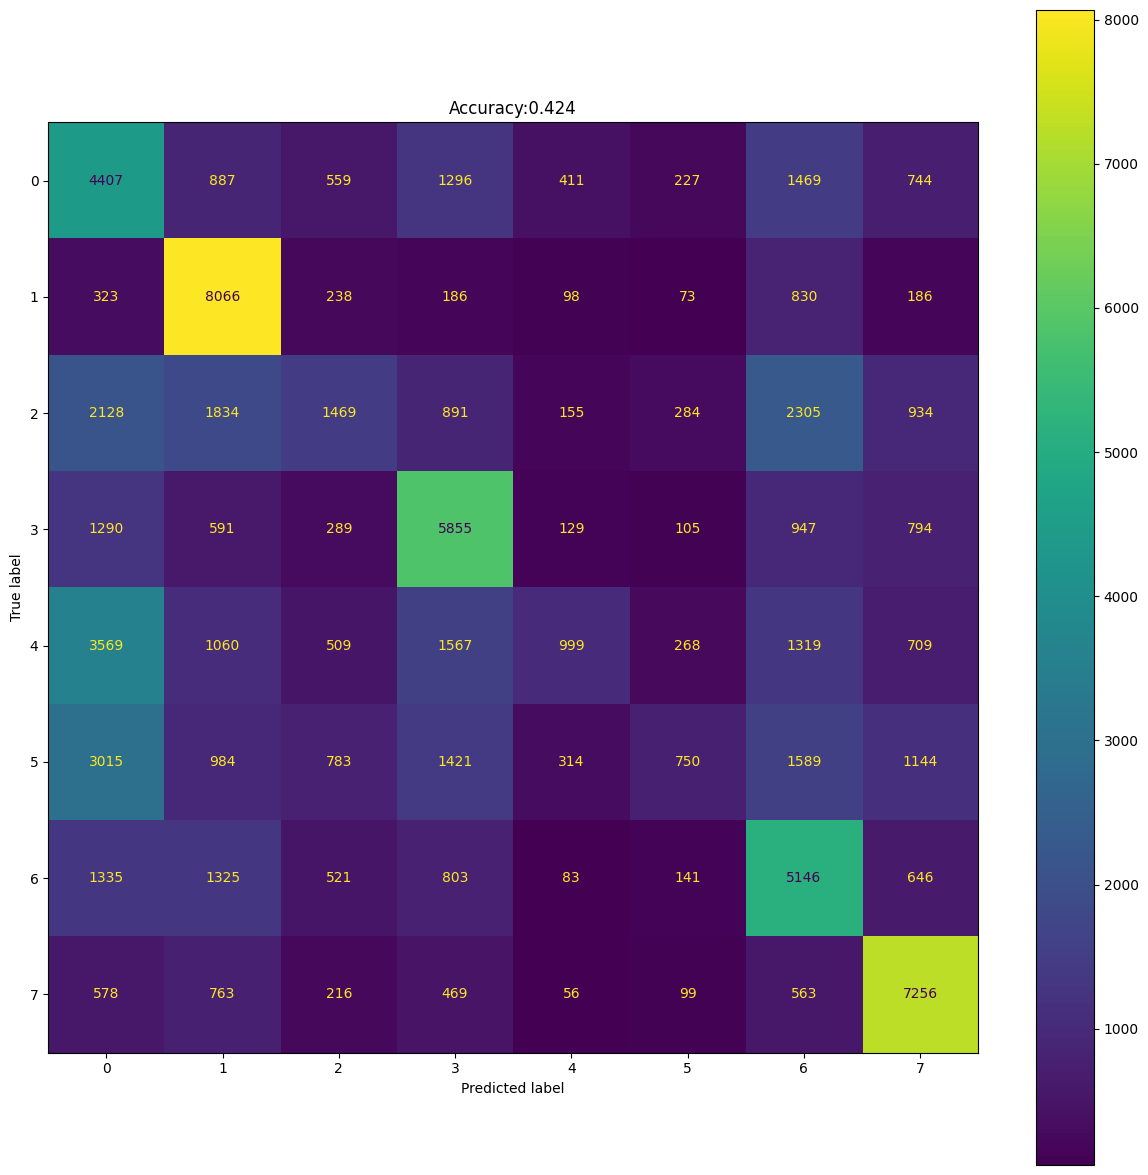

In [69]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(iv) dataset 

In [70]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [71]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 4.7878 - accuracy: 0.1185
test loss, test acc: [4.7878313064575195, 0.11846250295639038]


In [72]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 2 ... 4 5 2]
5
[[  14    9 2881  269  871 5496  188  272]
 [   3  116 2794  109 1425 5219  299   35]
 [  11   12 2782  432  974 5334  307  148]
 [   1    8 2520  107 1309 5806   57  192]
 [  18   14 3489  324 1079 4606  193  277]
 [  13   16 3242  316 1384 4648  159  222]
 [   2   18 3764  274 1977 3128  643  194]
 [  17   77 1921   85 2590 4988  234   88]]
              precision    recall  f1-score   support

           0       0.18      0.00      0.00     10000
           1       0.43      0.01      0.02     10000
           2       0.12      0.28      0.17     10000
           3       0.06      0.01      0.02     10000
           4       0.09      0.11      0.10     10000
           5       0.12      0.46      0.19     10000
           6       0.31      0.06      0.11     10000
           7       0.06      0.01      0.02     10000

    accuracy                           0.12     80000
   macro avg       0.17      0.12  

Test Accuracy:0.1184625


Text(0.5, 1.0, 'Accuracy:0.118')

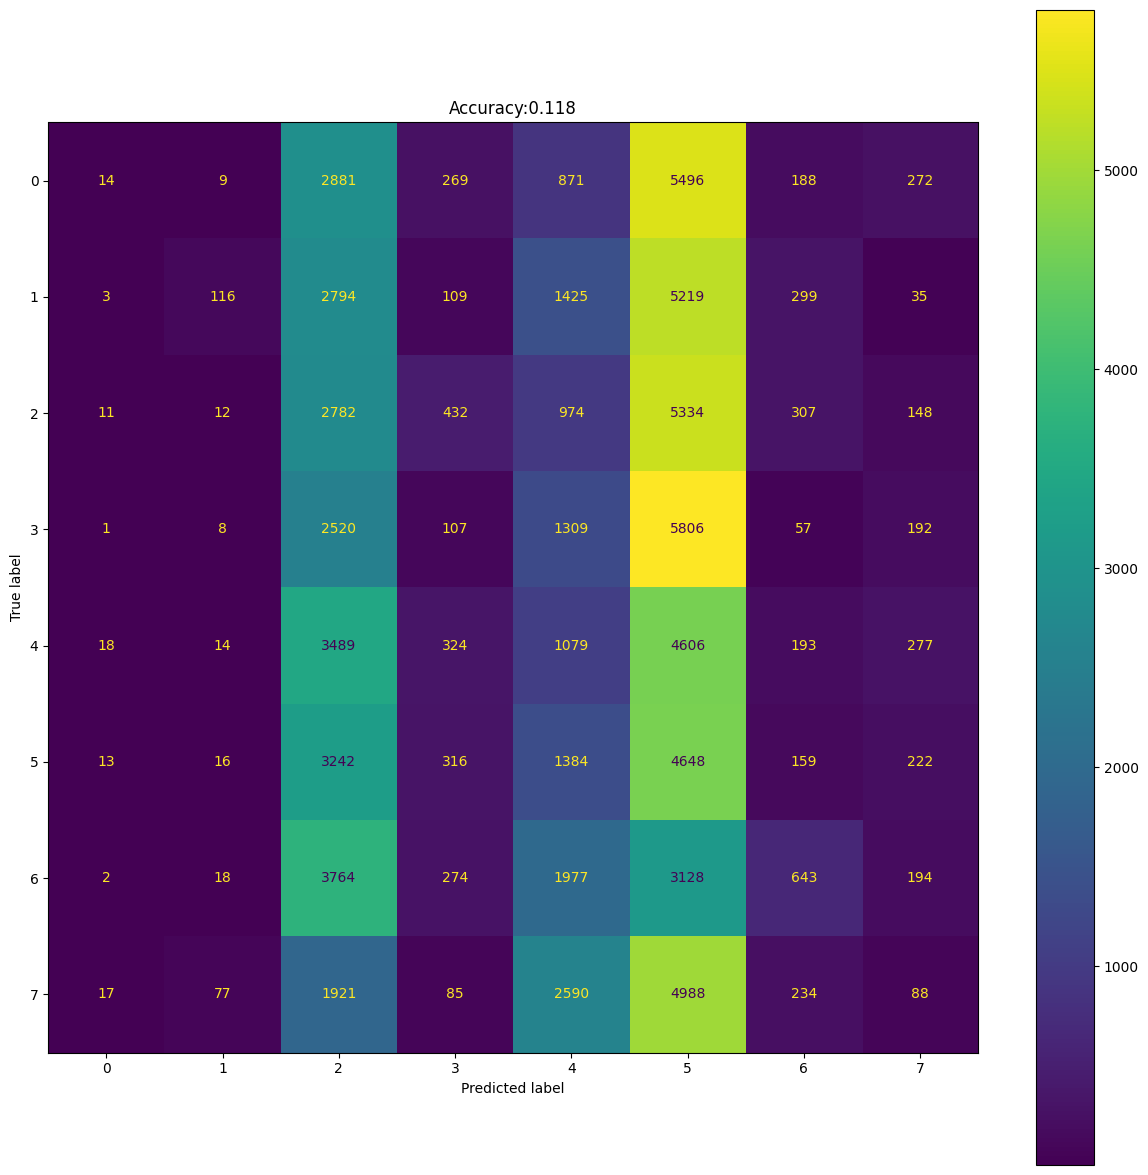

In [73]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [74]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [75]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [76]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.9912 - accuracy: 0.1518
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.2039 - accuracy: 0.1930
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9572 - accuracy: 0.2508
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8849 - accuracy: 0.2851
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8534 - accuracy: 0.3011
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8344 - accuracy: 0.3103
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8203 - accuracy: 0.3175
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8084 - accuracy: 0.3248
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7976 - accuracy: 0.3307
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

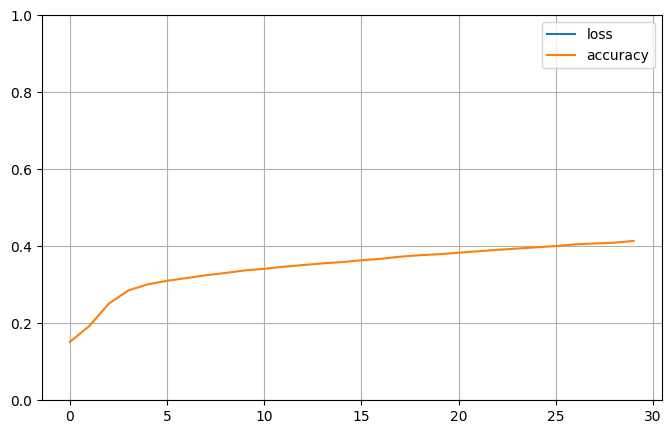

In [77]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [79]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.6499 - accuracy: 0.4150
test loss, test acc: [1.6498833894729614, 0.4149875044822693]


In [80]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 2 2 ... 7 3 3]
0
[[2035  933  876 1747 1414  538 1509  948]
 [ 198 6613  343  754  329  248 1047  468]
 [ 582 1185 2685 1472  863  527 1891  795]
 [ 525  901  517 5379  529  320 1178  651]
 [ 897  994  851 1409 2767  512 1548 1022]
 [ 818 1188 1009 1628 1255 1382 1599 1121]
 [ 344 1114  693  952  420  237 5539  701]
 [ 388  606  348  558  370  207  724 6799]]
              precision    recall  f1-score   support

           0       0.35      0.20      0.26     10000
           1       0.49      0.66      0.56     10000
           2       0.37      0.27      0.31     10000
           3       0.39      0.54      0.45     10000
           4       0.35      0.28      0.31     10000
           5       0.35      0.14      0.20     10000
           6       0.37      0.55      0.44     10000
           7       0.54      0.68      0.60     10000

    accuracy                           0.41     80000
   macro avg       0.40      0.41  

Test Accuracy:0.4149875


Text(0.5, 1.0, 'Accuracy:0.415')

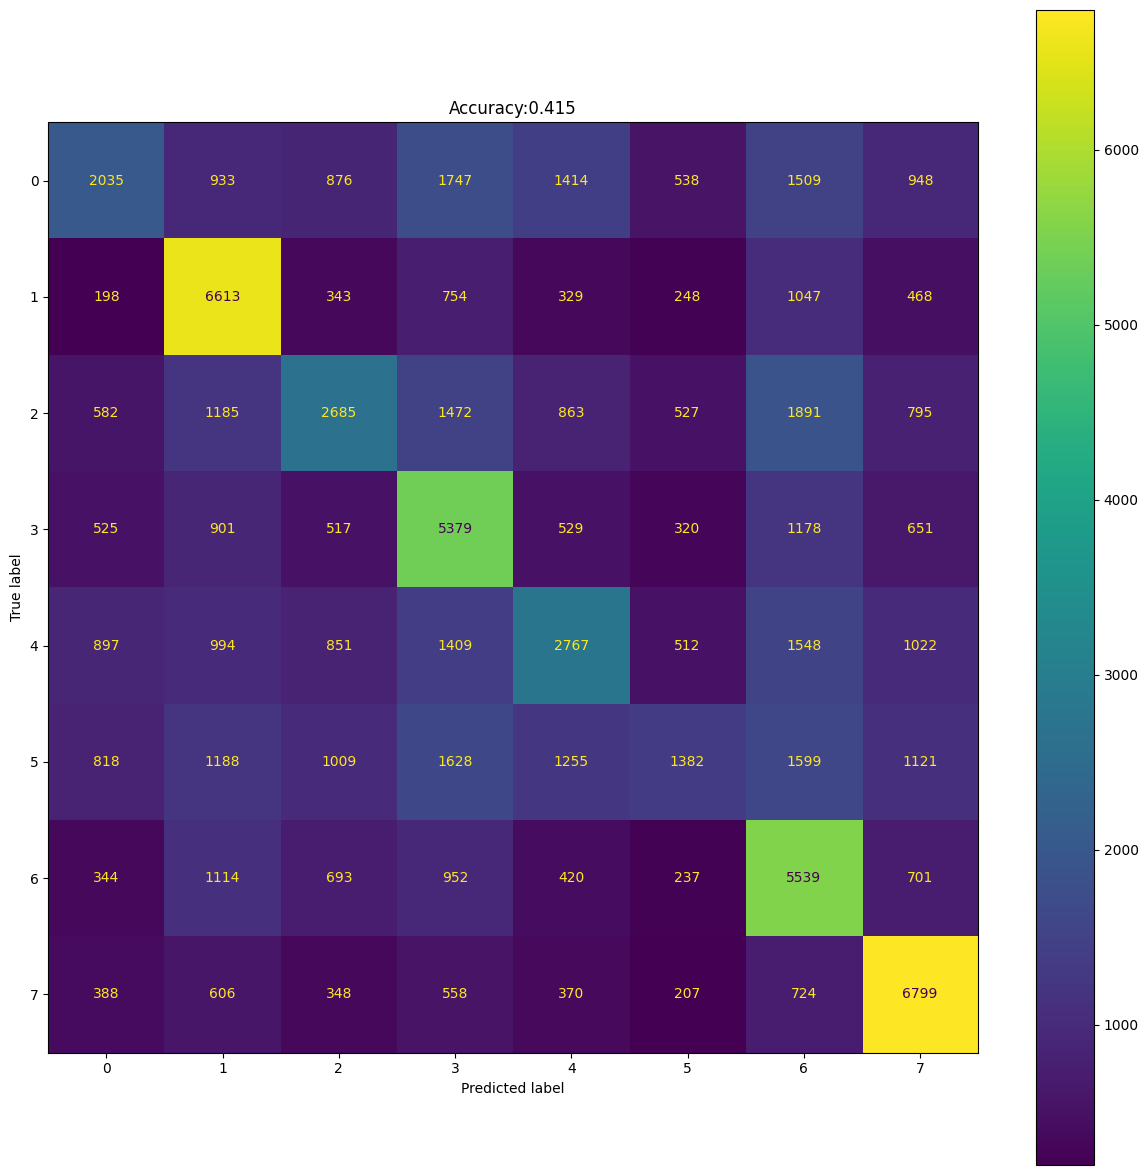

In [81]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-25(iv) dataset 

In [82]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [83]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 7.2138 - accuracy: 0.1274
test loss, test acc: [7.213847637176514, 0.12737500667572021]


In [84]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 5 ... 0 5 5]
0
[[ 678    0  339   25    0 8933   24    1]
 [3608    1 1099   20    0 5268    4    0]
 [2039    0  656   11    0 7285    9    0]
 [ 657    0  190    1    0 9144    8    0]
 [ 817    0  411   68    0 8689   15    0]
 [ 809    0  381   23    0 8772   14    1]
 [ 608    0  642    5    0 8661   82    2]
 [4980    0 1142   13    0 3863    2    0]]
              precision    recall  f1-score   support

           0       0.05      0.07      0.06     10000
           1       1.00      0.00      0.00     10000
           2       0.13      0.07      0.09     10000
           3       0.01      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.14      0.88      0.25     10000
           6       0.52      0.01      0.02     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.23      0.13  

Test Accuracy:0.127375


Text(0.5, 1.0, 'Accuracy:0.127')

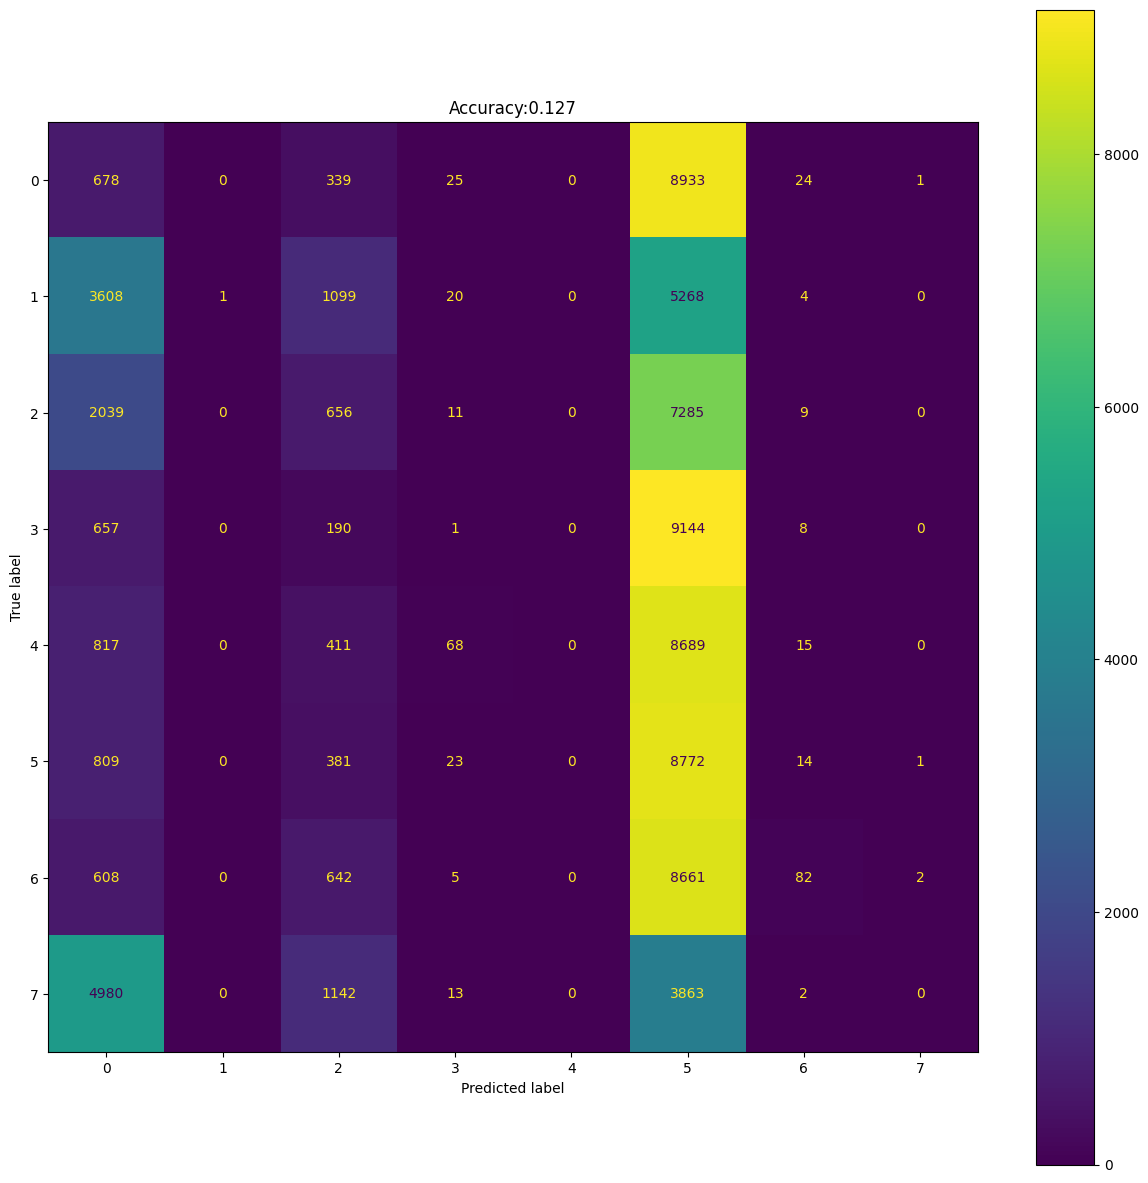

In [85]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [86]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [87]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [88]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.9845 - accuracy: 0.1384
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.0269 - accuracy: 0.2279
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8849 - accuracy: 0.2714
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8398 - accuracy: 0.2870
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8150 - accuracy: 0.2989
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7971 - accuracy: 0.3067
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7827 - accuracy: 0.3147
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7700 - accuracy: 0.3229
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7585 - accuracy: 0.3295
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

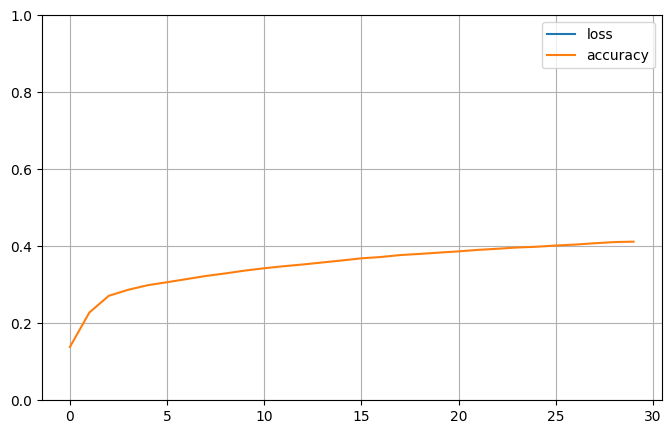

In [89]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [90]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.6092 - accuracy: 0.4182
test loss, test acc: [1.60923433303833, 0.4181874990463257]


In [91]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 7 0 ... 7 3 3]
7
[[2468  682 1121 1312 2342  158 1400  517]
 [ 170 7159  338  375  576   40  606  736]
 [ 717 1051 2755 1409 1203  119 1302 1444]
 [ 508  450  779 5947  584  126 1065  541]
 [1476  569 1253 1043 3599  160 1207  693]
 [1472  763 1362 1602 1927  498 1792  584]
 [ 577  747  849 1822 1046  122 4330  507]
 [ 182 1048  436  581  511   32  511 6699]]
              precision    recall  f1-score   support

           0       0.33      0.25      0.28     10000
           1       0.57      0.72      0.64     10000
           2       0.31      0.28      0.29     10000
           3       0.42      0.59      0.49     10000
           4       0.31      0.36      0.33     10000
           5       0.40      0.05      0.09     10000
           6       0.35      0.43      0.39     10000
           7       0.57      0.67      0.62     10000

    accuracy                           0.42     80000
   macro avg       0.41      0.42  

Test Accuracy:0.4181875


Text(0.5, 1.0, 'Accuracy:0.418')

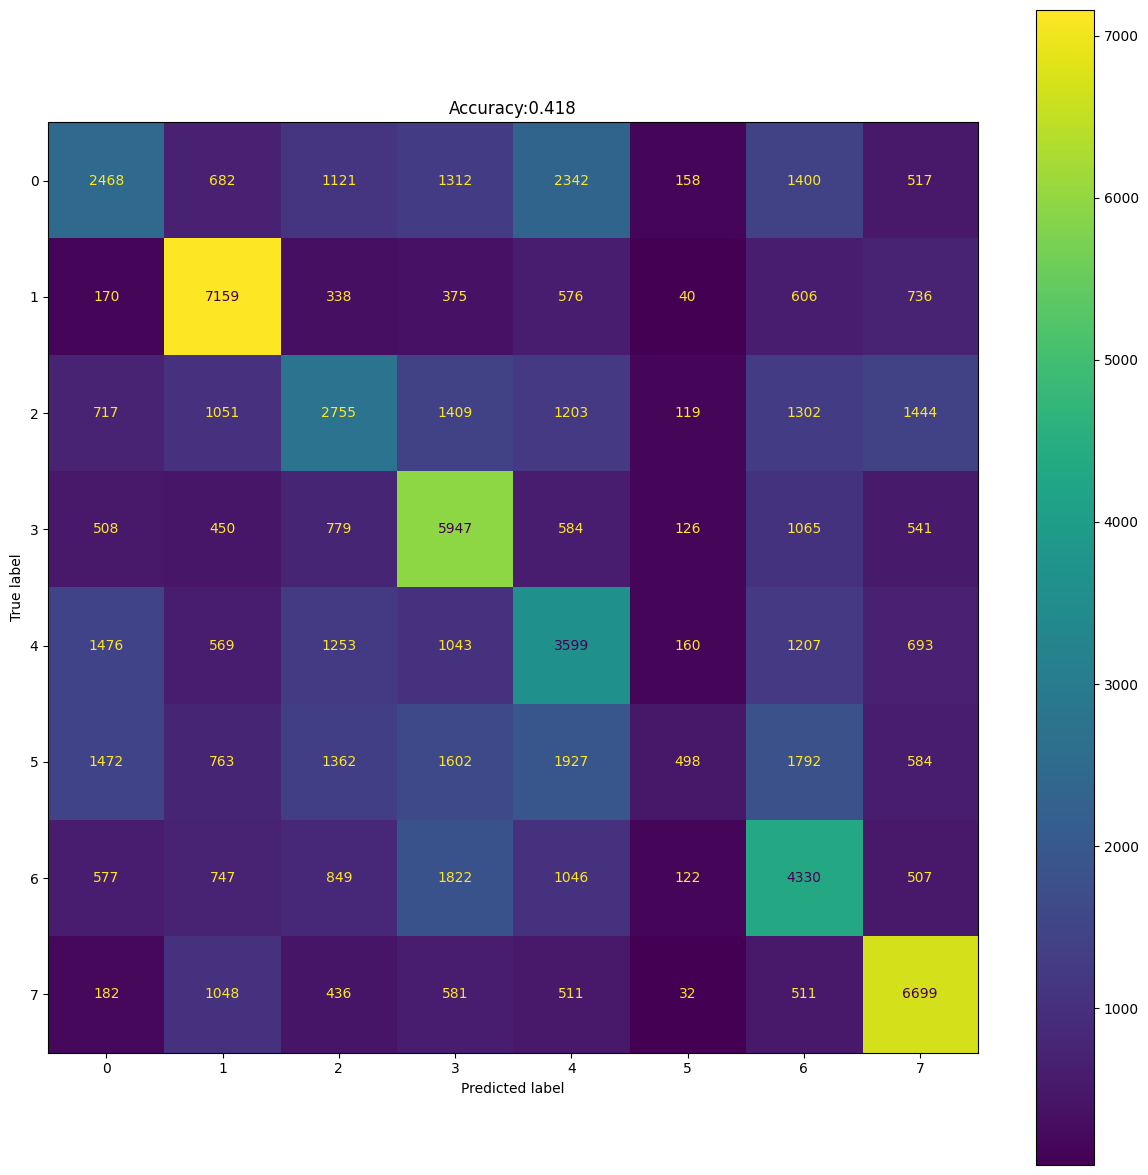

In [92]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-25(iv) dataset 

In [93]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [94]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 5.8148 - accuracy: 0.1273
test loss, test acc: [5.814835071563721, 0.12729999423027039]


In [95]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 0 5 ... 0 5 5]
5
[[5378    3  422  199    0 3973   13   12]
 [6413    8  125   34    0 3357   60    3]
 [5567    3  328   91    0 3989   21    1]
 [3513    2  255   39    0 6181    8    2]
 [4169    1  269  191    0 5356   11    3]
 [5107    3  409  123    0 4335   22    1]
 [6461    6  718   55    0 2669   90    1]
 [6383    1  374   52    0 3173   11    6]]
              precision    recall  f1-score   support

           0       0.13      0.54      0.20     10000
           1       0.30      0.00      0.00     10000
           2       0.11      0.03      0.05     10000
           3       0.05      0.00      0.01     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.43      0.20     10000
           6       0.38      0.01      0.02     10000
           7       0.21      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.16      0.13  

Test Accuracy:0.1273


Text(0.5, 1.0, 'Accuracy:0.127')

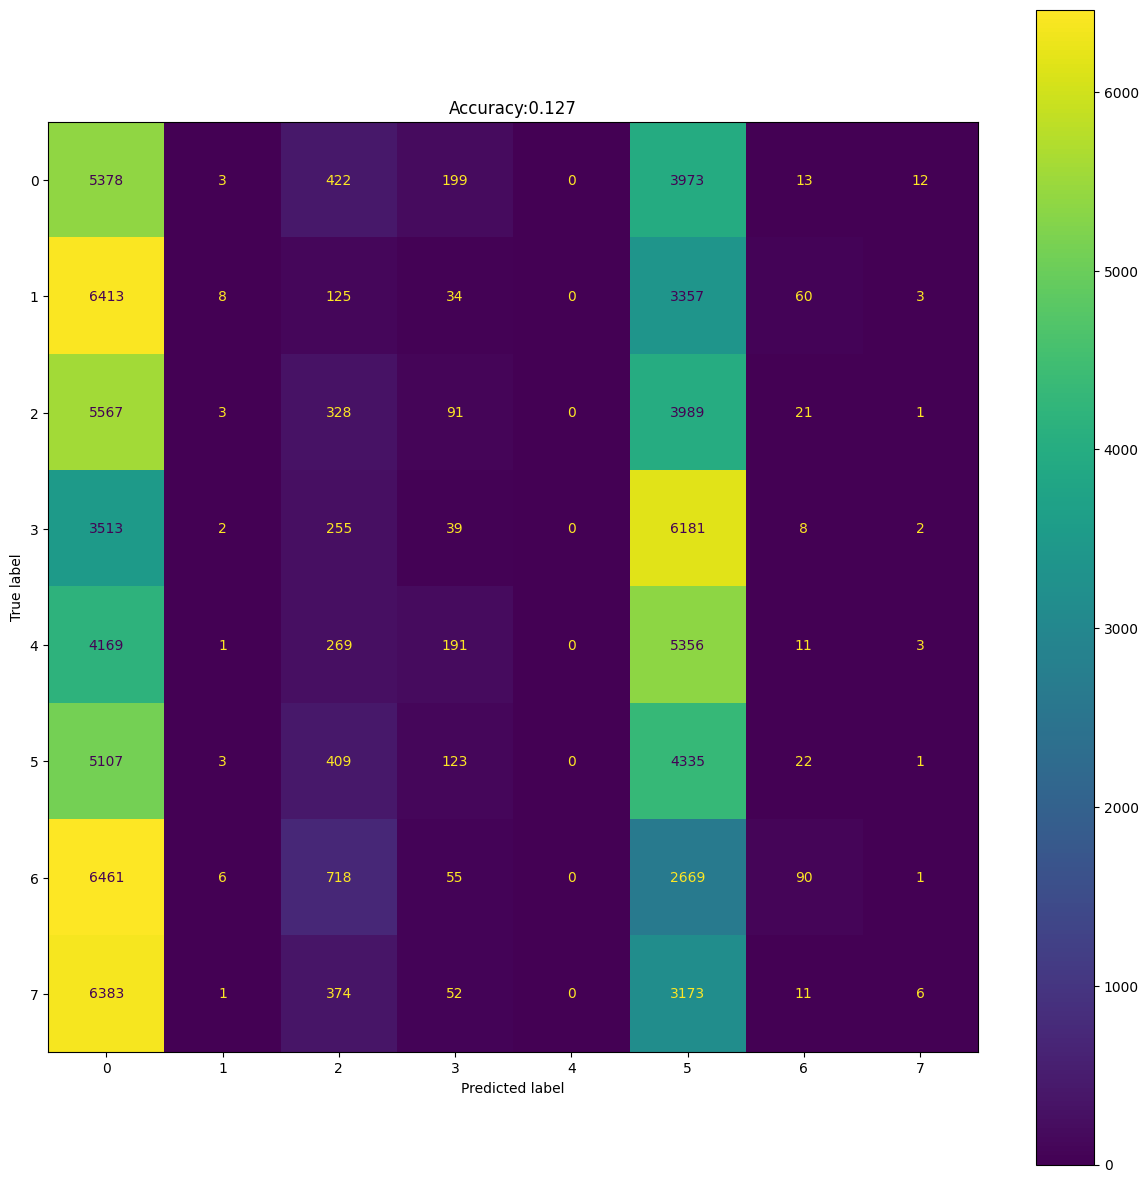

In [96]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [97]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [98]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [99]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8996 - accuracy: 0.1375
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.2964 - accuracy: 0.1620
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.0714 - accuracy: 0.1940
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9775 - accuracy: 0.2307
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9294 - accuracy: 0.2585
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8999 - accuracy: 0.2775
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8794 - accuracy: 0.2895
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8637 - accuracy: 0.3007
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8504 - accuracy: 0.3070
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.83

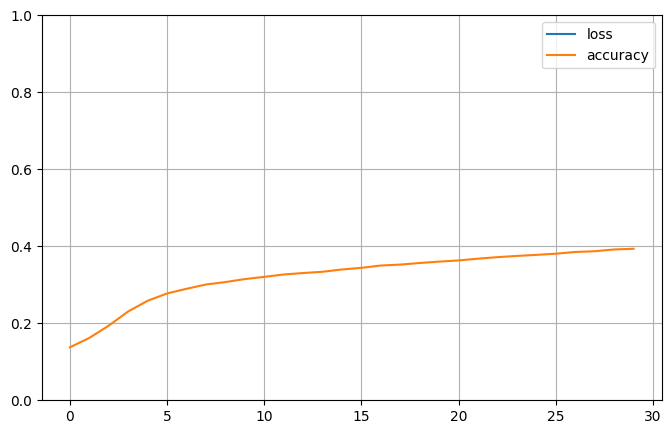

In [100]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [101]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.6928 - accuracy: 0.3965
test loss, test acc: [1.6928443908691406, 0.39649999141693115]


In [102]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 7 0 ... 7 7 7]
4
[[2333  756  254 1239 2494  822 1172  930]
 [ 298 6098  187 1095  648  221 1047  406]
 [ 567 1058 1241 1513 2121  595 1574 1331]
 [ 409  878  245 5706 1081  403  764  514]
 [1072  655  527 1135 4631  480  727  773]
 [1092  879  504 1804 2046 1336 1306 1033]
 [ 591 1535  541 1250  935  391 3964  793]
 [ 205  450  217 1227  923   91  476 6411]]
              precision    recall  f1-score   support

           0       0.36      0.23      0.28     10000
           1       0.50      0.61      0.55     10000
           2       0.33      0.12      0.18     10000
           3       0.38      0.57      0.46     10000
           4       0.31      0.46      0.37     10000
           5       0.31      0.13      0.19     10000
           6       0.36      0.40      0.38     10000
           7       0.53      0.64      0.58     10000

    accuracy                           0.40     80000
   macro avg       0.38      0.40  

Test Accuracy:0.3965


Text(0.5, 1.0, 'Accuracy:0.397')

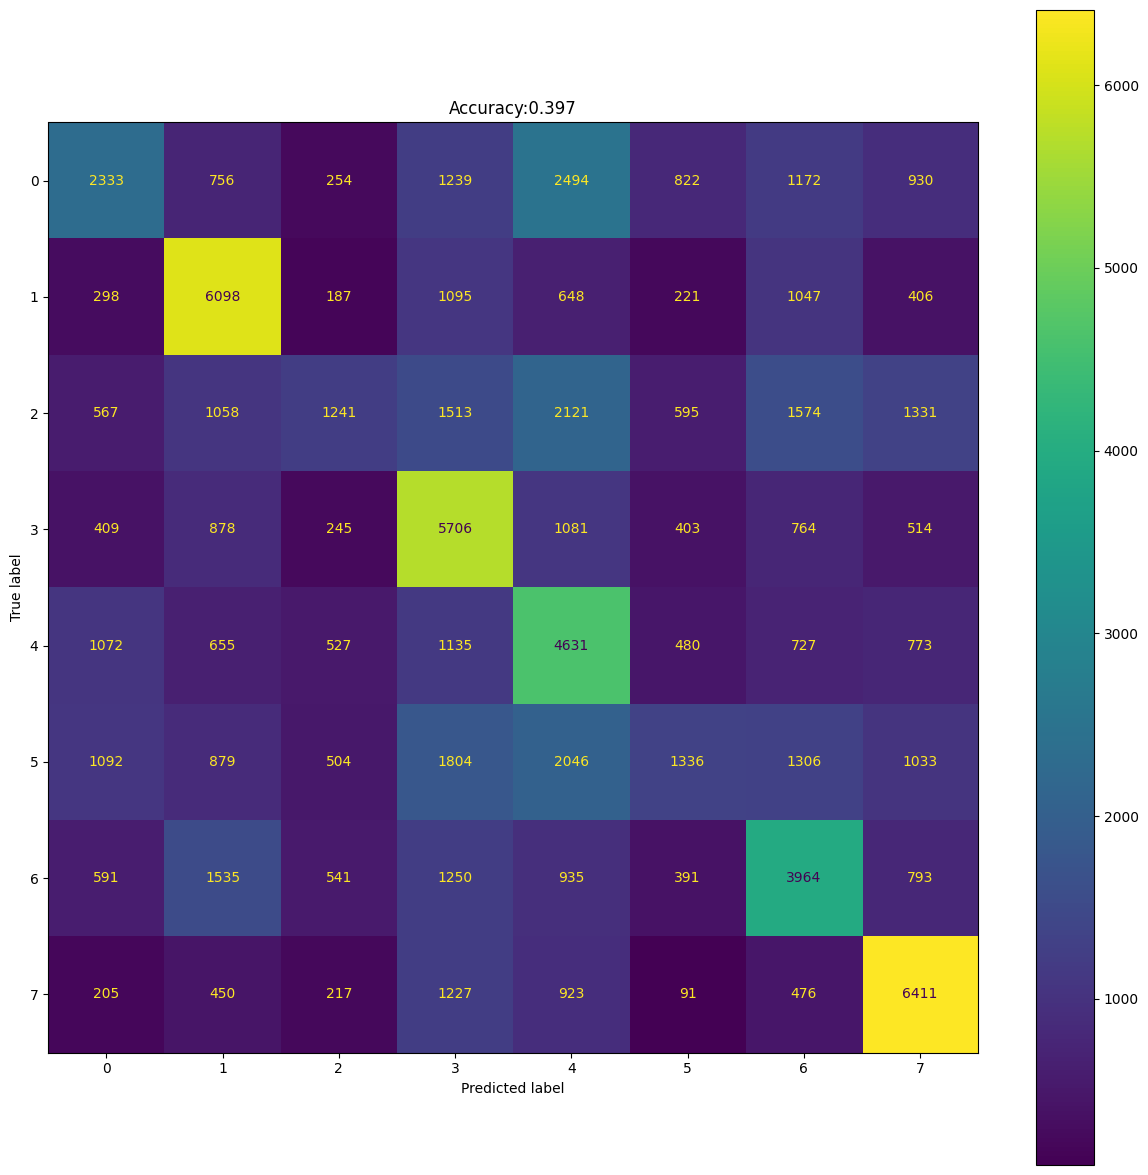

In [103]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')